In [1]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [3]:
#%% 
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import textwrap
 


#Helpers and functions
from helpers import select_top_n, prepare_data, plotbar_multi, df_explode

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

sns.set_theme(style="ticks", palette=palette)


from pandas_profiling import ProfileReport

%matplotlib inline




# Data Analysis Notebook

This notebook is intended to do a quick Explorational Data Analysis (EDA) to understand the main features and artefacts of the dataset. 

First, we need to load the data and clean it up before running any analysis. 

In [4]:
data = pd.read_csv('/Users/manu/dev/SonarSource_code/survey_results_public.csv', index_col='ResponseId')
data_schema = pd.read_csv('/Users/manu/dev/SonarSource_code/survey_results_schema.csv')

I'm using some helper functions that I wrote on the imported file `helpers.py` to clean up the data. This file contains some functions I defined to help with the data analysis. Most of the helper functions' ideas were extracted from the internet, using StackOverflow or the official Pandas or Seaborn documentation.

In [5]:
data, data_schema = prepare_data(data,data_schema)

I used [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) for a quick data overview.

In [6]:
profile = ProfileReport(data, title="StackOverflow Developper survey 2021", minimal=True)
profile.to_widgets()
%matplotlib inline

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Some basic plots

Now we did a quick data exploration with pandas profiling; let's do some plots to compare them with the official report to be sure we have the correct data:

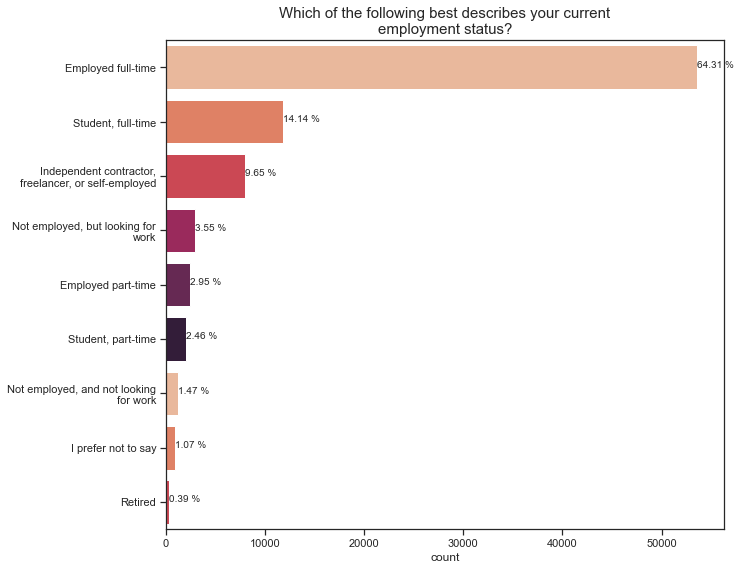

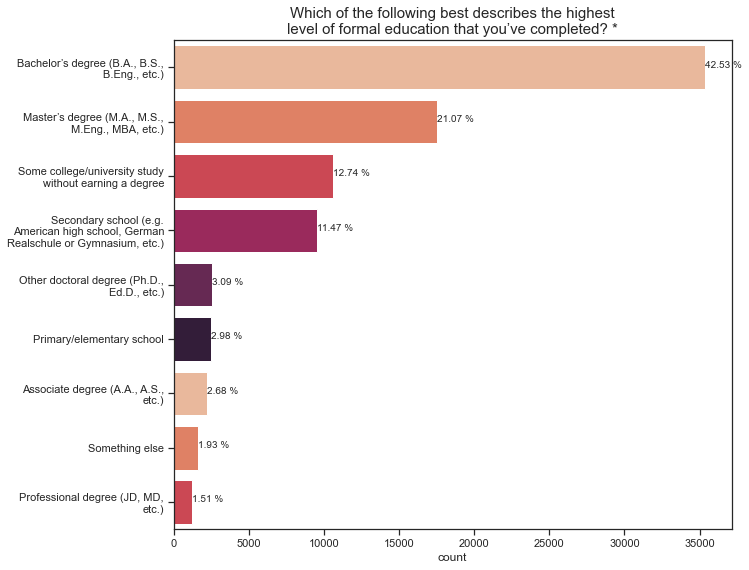

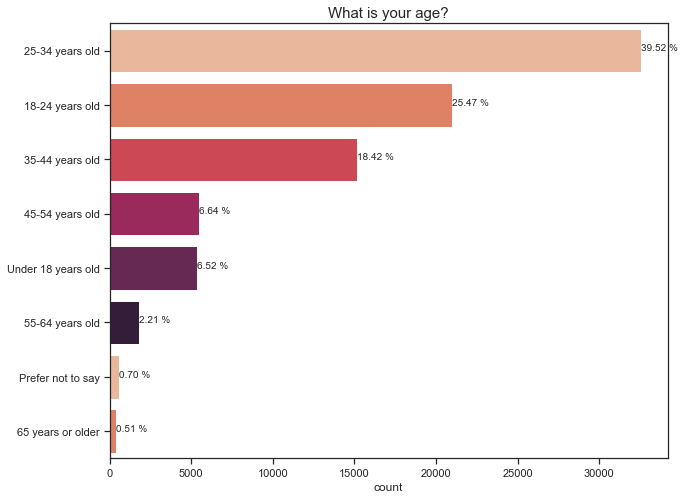

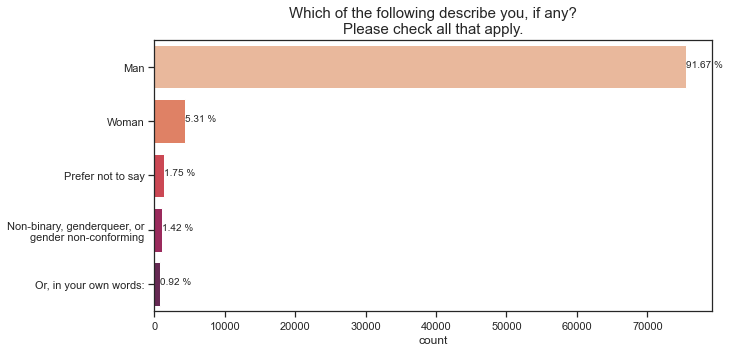

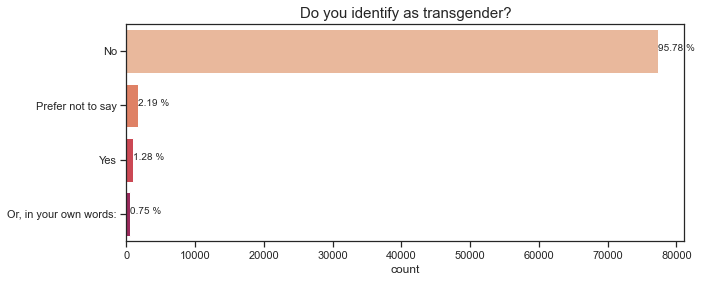

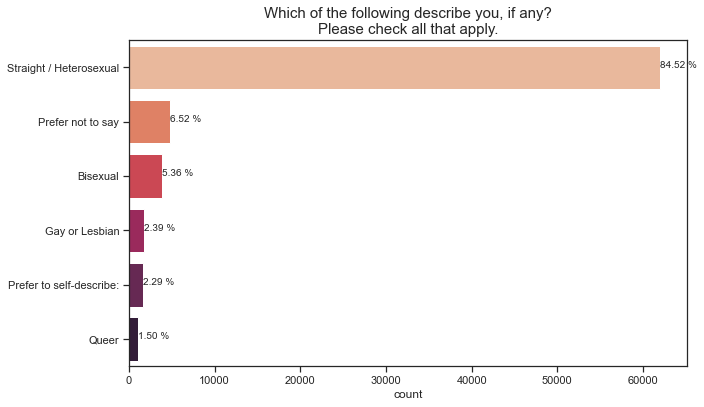

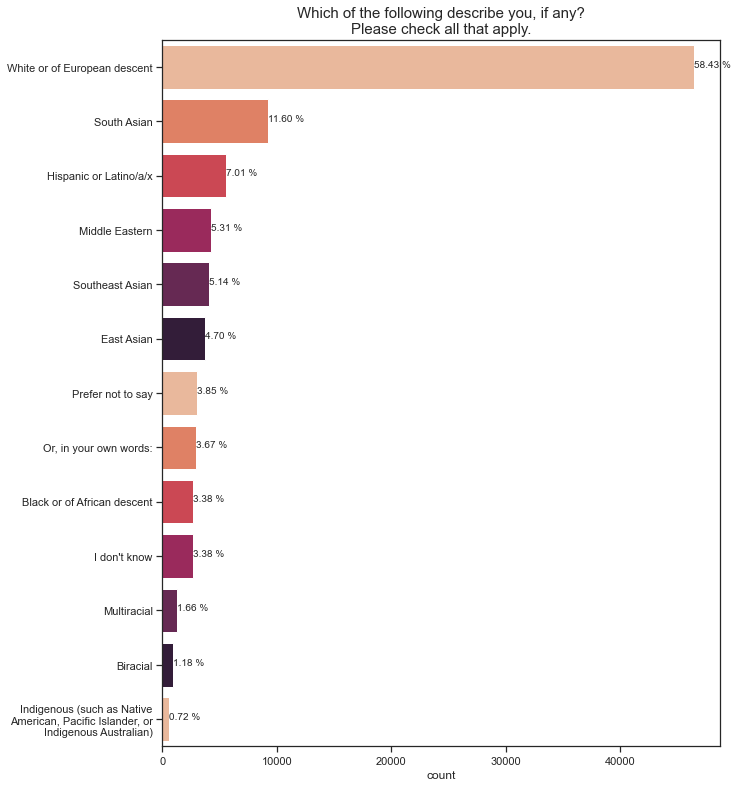

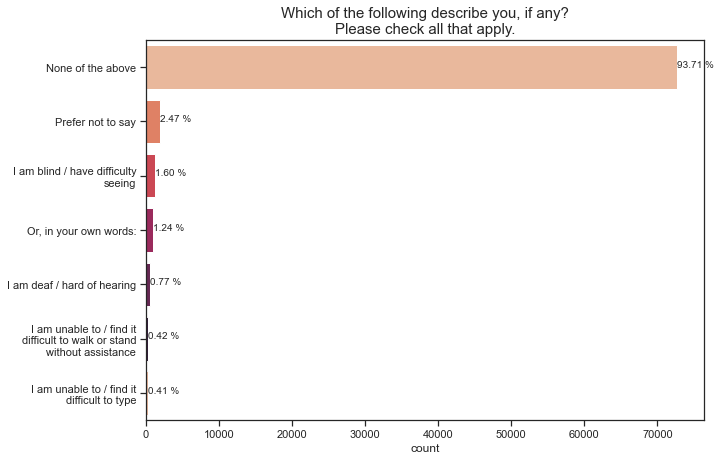

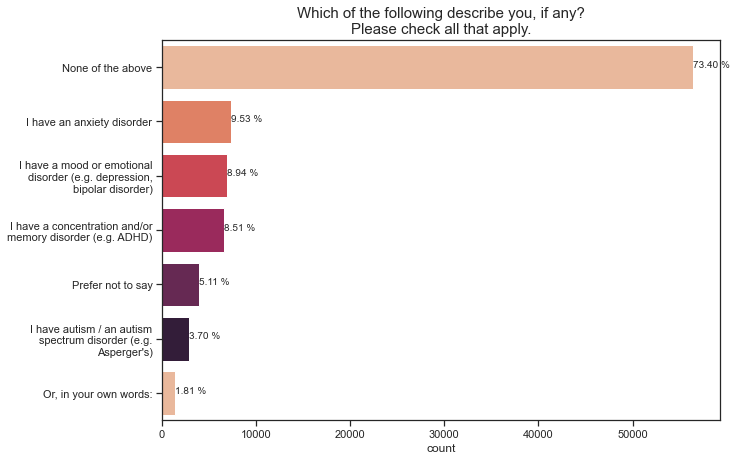

In [7]:
plot_list = ['Employment',                                    
'EdLevel'                     ,
'Age'                          ,
'Gender'                       ,
'Trans'                        ,
'Sexuality'                    ,
'Ethnicity'                    ,
'Accessibility'                ,
'MentalHealth'                 ]

for var in plot_list:
    plt.figure(figsize=(10,len(data[var].str.split(';', expand=True).stack().value_counts(normalize=True).index)))
    plotbar_multi(data,var, order=True)
    plt.title(textwrap.fill(data_schema.loc[data_schema['qname'] == var, 'question'].values[0],50), fontsize=15)



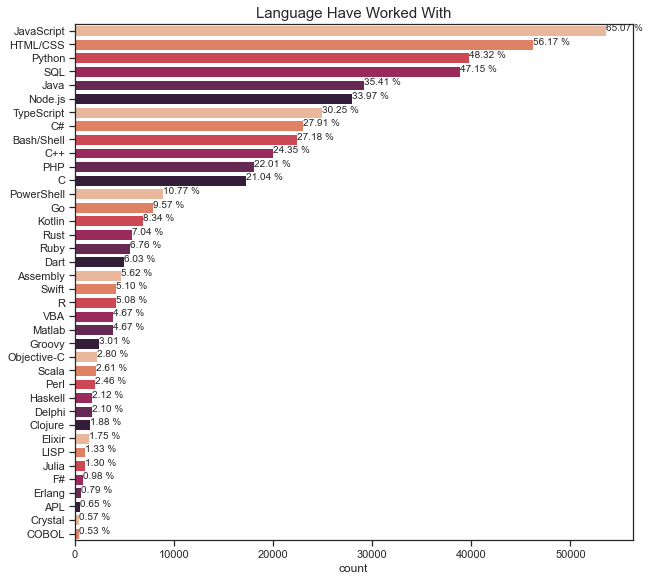

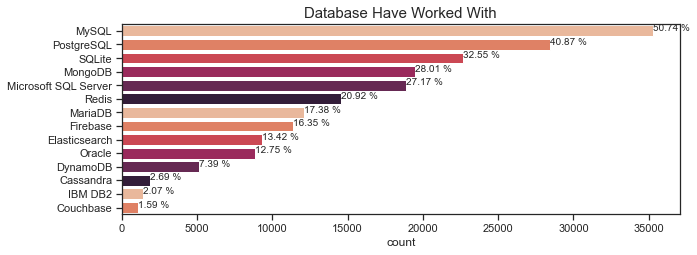

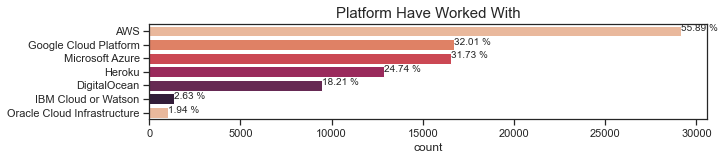

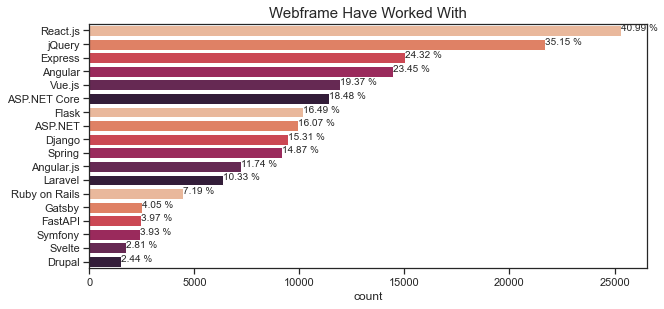

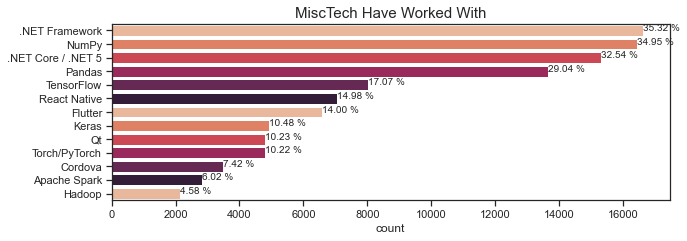

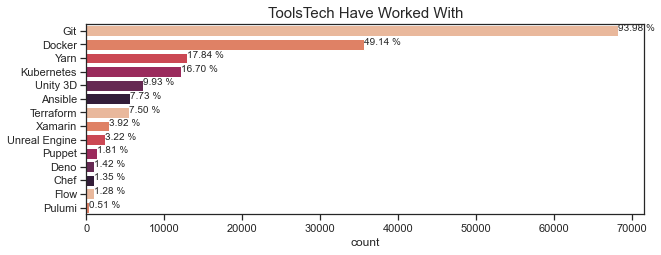

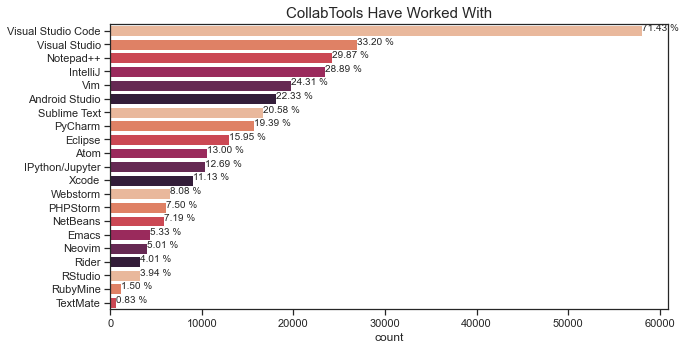

In [8]:
plot_list = ['LanguageHaveWorkedWith'       ,
            'DatabaseHaveWorkedWith'       ,
            'PlatformHaveWorkedWith'       ,
            'WebframeHaveWorkedWith'       ,
            'MiscTechHaveWorkedWith'       ,
            'ToolsTechHaveWorkedWith'      ,
            'NEWCollabToolsHaveWorkedWith' 
                ]


for var in plot_list:
    plt.figure(figsize=(10,len(data[var].str.split(';', expand=True).stack().value_counts(normalize=True).index)/4))
    plotbar_multi(data,var, order=True)
    plt.title(data_schema.loc[data_schema['qname'] == var, 'question'].values[0], fontsize=15)






In [9]:
fig = go.Figure(data=go.Choropleth(
    locations = data['Alpha_3'].unique(),
    z = data.groupby(['Alpha_3'], sort=False)['Country'].count().tolist(),
    text = data.groupby(['Alpha_3'], sort=False)['Country'].count().tolist(),
    colorscale = 'sunsetdark',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '#',
    colorbar_title = 'Number of users',
))

fig.update_layout(
    title_text='Participants distribution',
    geo=dict(
        showframe=True,
        showcoastlines=True,
        projection_type='equirectangular'
    )
)

fig.show()

The plots show the same information as the [Stack Overflow official report](https://insights.stackoverflow.com/survey/2021). Therefore, we can continue.

## Applying some cuts

The United States of America and India represent 31% of the dataset over 181 countries. We can display some plots grouped by country to understand if the dataset's content is biased by those two countries. Since it is not feasible to represent all the countries, I will apply a cut on the top 5 most common countries.


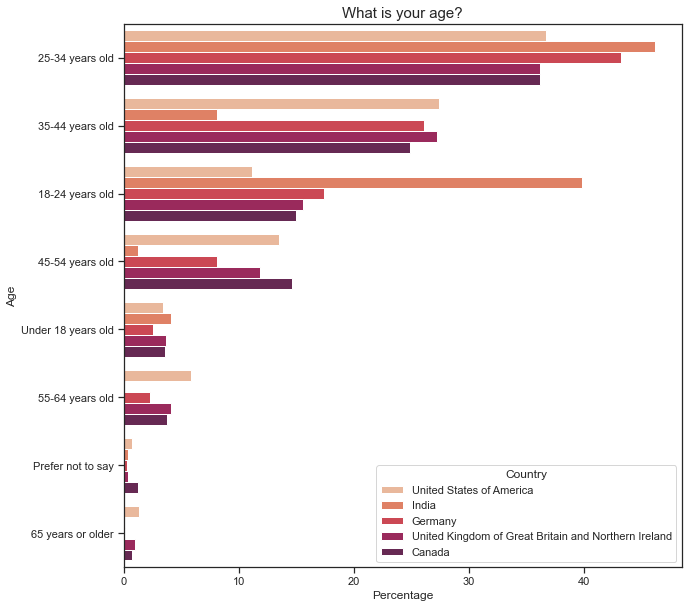

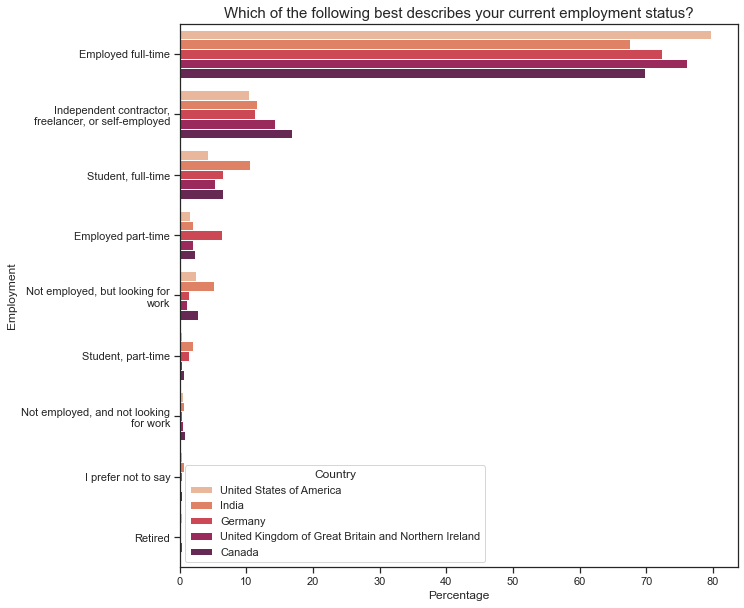

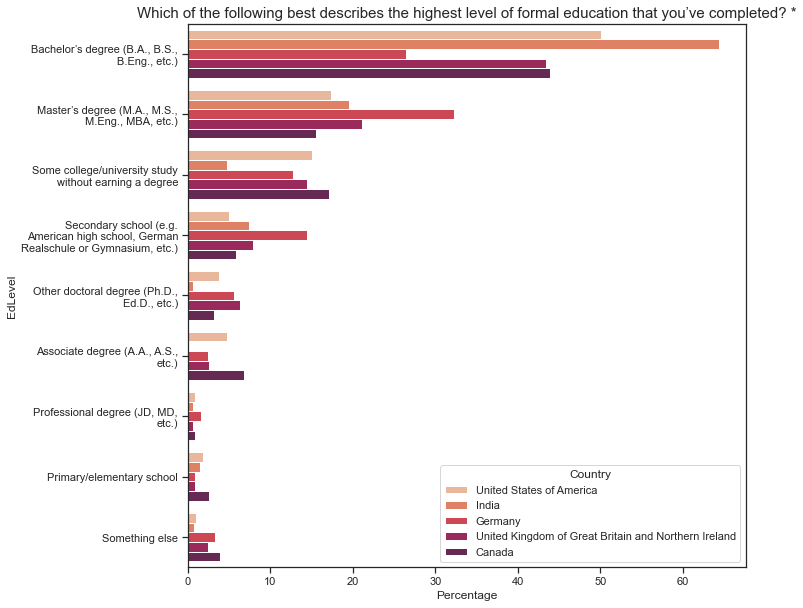

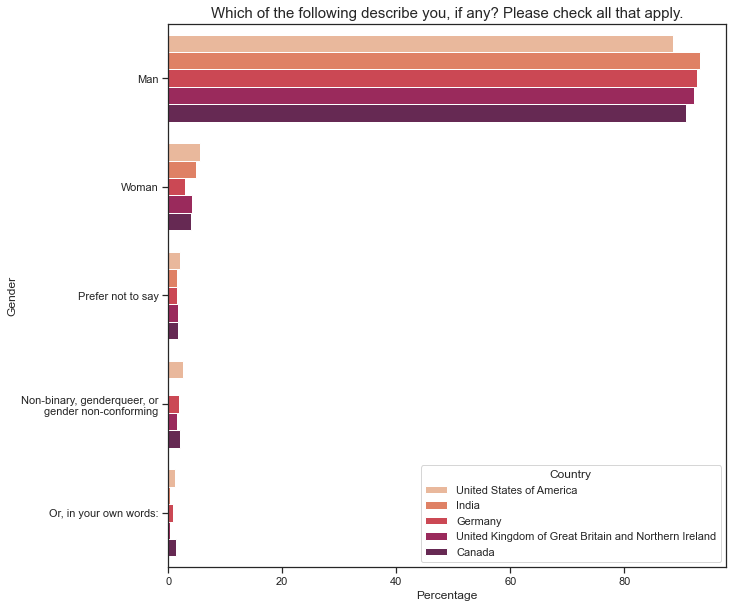

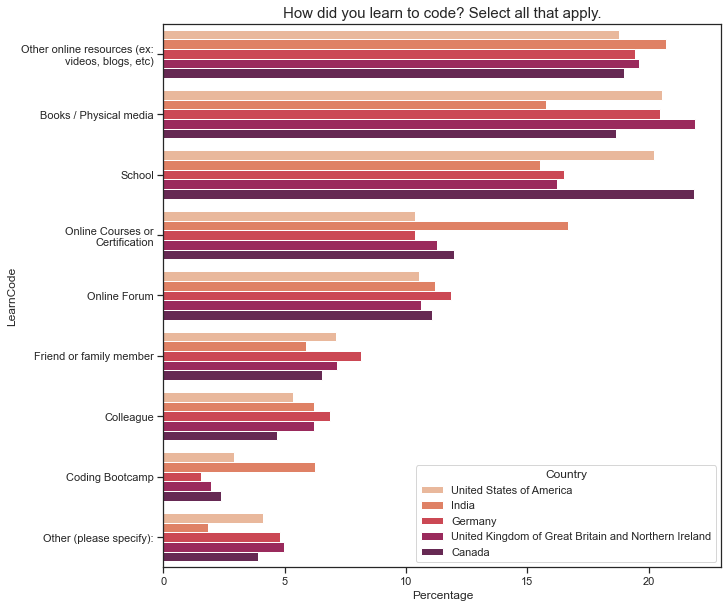

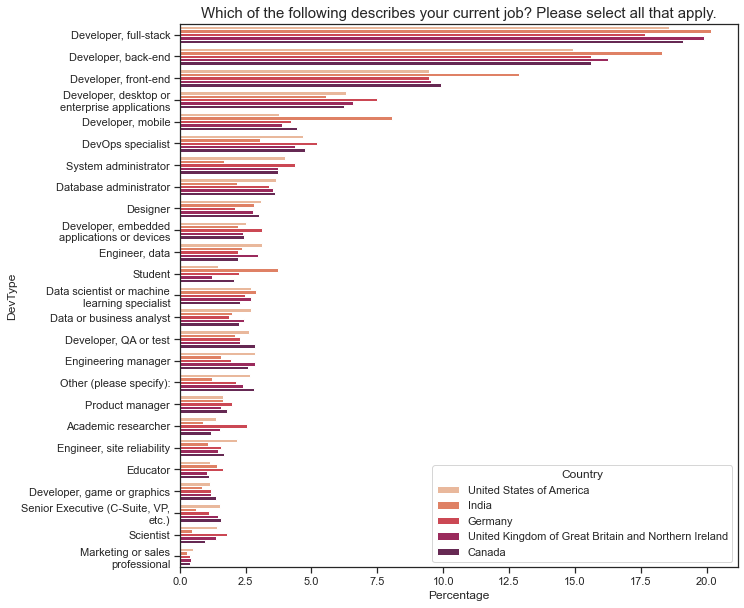

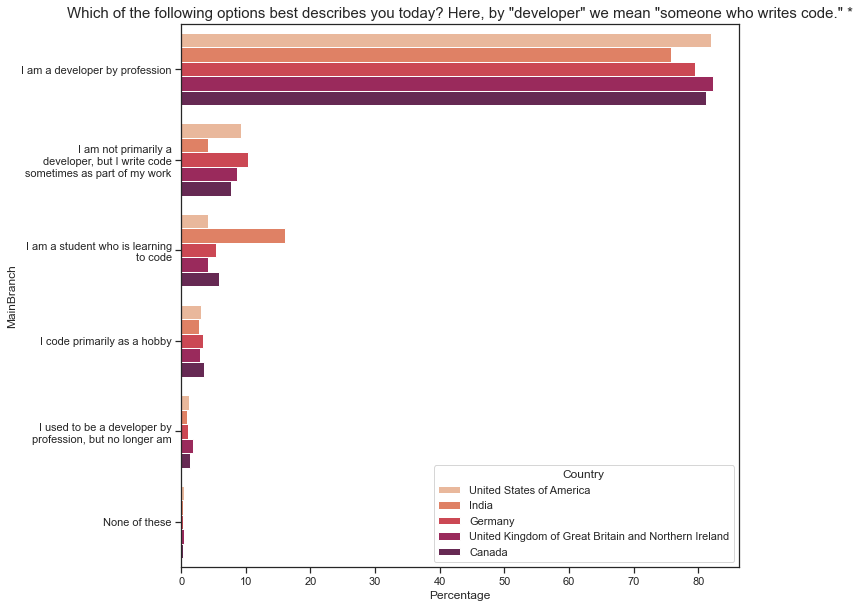

In [10]:
aux = df_explode(data,'DevType')                          #For multi-choice option the Dataset need to be expanded for
aux = df_explode(aux.reset_index(drop=True), 'Gender')    # all the different options.
aux = df_explode(aux.reset_index(drop=True), 'LearnCode')

for var_to_study in ['Age',
                     'Employment',
                     'EdLevel',
                     'Gender',
                     'LearnCode',
                     'DevType',
                     'MainBranch']:
            
    
    plt.figure(figsize=(10,10))
    # We select the top5 countries with the helper function select_top_n,
    # group by the variable to plot, calculate the percentage
    # and clean up the variable to be plotted correctly
    ed_counts = (aux.loc[aux['Country'].isin(select_top_n(data['Country']))].groupby(['Country'])[var_to_study]
                         .value_counts(normalize=True)
                         .rename('Percentage')
                         .mul(100)
                         .reset_index(level=0)
                         .reset_index(level=0)
                         .rename(columns={'index': var_to_study}))

    ax = sns.barplot( data=ed_counts,
                      x='Percentage',
                      hue='Country',
                      y=var_to_study,
                      orient='h',
                      order=aux[var_to_study].value_counts().index,
                      hue_order=aux.loc[aux['Country'].isin(select_top_n(data['Country'])),'Country'].value_counts().index,
                      palette=palette)
    plt.title(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0], fontsize=15)
    labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
    _ = ax.set_yticklabels(labelsy)
    

We could assume that the categories are well represented among the countries with few exceptions. We could do the same for the gender:


In [ ]:
aux = df_explode(data,'DevType')                          #For multi-choice option the Dataset need to be expanded for
aux = df_explode(aux.reset_index(drop=True), 'Gender')    # all the different options.
aux = df_explode(aux.reset_index(drop=True), 'LearnCode')

for var_to_study in ['Age',
                     'Employment',
                     'EdLevel',
                     'LearnCode',
                     'DevType',
                     'MainBranch']:
            
    
    plt.figure(figsize=(10,10))
    ed_counts = (aux.loc[aux['Gender'].isin(select_top_n(data['Gender']))].groupby(['Gender'])[var_to_study]
                         .value_counts(normalize=True)
                         .rename('Percentage')
                         .mul(100)
                         .reset_index(level=0)
                         .reset_index(level=0)
                         .rename(columns={'index': var_to_study}))

    ax = sns.barplot( data=ed_counts,
                      x='Percentage',
                      hue='Gender',
                      y=var_to_study,
                      orient='h',
                      order=aux[var_to_study].value_counts().index,
                      hue_order=aux.loc[aux['Gender'].isin(select_top_n(data['Gender'])),'Gender'].value_counts().index,
                      palette=palette)
    plt.title(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0], fontsize=15)
    labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
    _ = ax.set_yticklabels(labelsy)

As for the Countries, gender is generally well represented among the categories.

### Some other groups

To extract similar results as on the official report, we could apply some cuts based on how users learnt to code or where they are coming from.

In [ ]:
plt.figure(figsize=(10,10))

ed_counts = (data.groupby(['Continent'])['EdLevel']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index(level=0)
                     .reset_index(level=0)
                     .rename(columns={'index': 'EdLevel'}))

ax = sns.barplot( data=ed_counts,
                  x='Percentage',
                  hue='Continent',
                  y='EdLevel',
                  orient='h',
                  order=data['EdLevel'].value_counts().index,
                  hue_order=data['Continent'].value_counts().index,
                  palette=palette)
plt.title(data_schema.loc[data_schema['qname'] == 'EdLevel', 'question'].values[0], fontsize=15)
labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
_ = ax.set_yticklabels(labelsy)

In [ ]:
plt.figure(figsize=(10,10))

age_counts = (data.groupby(['Continent'])['Age']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index(level=0)
                     .reset_index(level=0)
                     .rename(columns={'index': 'Age'}))

ax = sns.barplot( data=age_counts,
                  x='Percentage',
                  hue='Continent',
                  y='Age',
                  orient='h',
                  order=data['Age'].value_counts().index,
                  hue_order=data['Continent'].value_counts().index,
                  palette=palette)
plt.title(data_schema.loc[data_schema['qname'] == 'Age', 'question'].values[0], fontsize=15)
labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
_=ax.set_yticklabels(labelsy)

In [ ]:
plt.figure(figsize=(10,10))

learn_code = (data.groupby(['Continent'])['LearnCode']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index(level=0)
                     .reset_index(level=0)
                     .rename(columns={'index': 'LearnCode'}))
learn_code['LearnCode'] = learn_code['LearnCode'].str.split(';')
learn_code = learn_code.explode('LearnCode')

ax = sns.barplot( data=learn_code,
                  x='Percentage',
                  hue='Continent',
                  y='LearnCode',
                  orient='h',
                  palette=palette,
                 ci=None
                )
plt.title(data_schema.loc[data_schema['qname'] == 'LearnCode', 'question'].values[0], fontsize=15)
labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
_=ax.set_yticklabels(labelsy)

In [ ]:
plt.figure(figsize=(10,10))





learn_code = (df_explode(data[['LearnCode', 'Continent']],'LearnCode').groupby(['Continent'])['LearnCode']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Continent'))


ax = sns.barplot( data=learn_code,
                  x='Percentage',
                  hue='LearnCode',
                  y='Continent',
                  orient='h',
                  palette=palette,
                 ci=None
                )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(data_schema.loc[data_schema['qname'] == 'LearnCode', 'question'].values[0], fontsize=15)
labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
_= ax.set_yticklabels(labelsy)

In [ ]:
plt.figure(figsize=(10,10))

learn_code = (df_explode(data[['LearnCode', 'Age']],'LearnCode').groupby(['Age'])['LearnCode']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Age'))


ax = sns.barplot( data=learn_code,
                  x='Percentage',
                  hue='LearnCode',
                  y='Age',
                  orient='h',
                  palette=palette,
                 ci=None
                )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(data_schema.loc[data_schema['qname'] == 'LearnCode', 'question'].values[0], fontsize=15)
labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
_ =  ax.set_yticklabels(labelsy)

## EDA Finished

With this, we can conclude or fast EDA. We have categorized our data, understood the missing values and studied the possible bias derived from the most significant categories. Now the data analysis starts on the notebook: `market_weakness.py`, where I'll try to find some market weaknesses or areas to explore deeper with further study.